## Build MRCNN Model
Pass data through MRCNN and then FCN and investigte output values from FCN
- First we generate the heatmaps, and also visually cehck them. 
- the we pass the heatmaps to the routine that prodcues the scores 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
from datetime import datetime   
sys.path.append('../')
print(os.getcwd())
# import mrcnn.utils        as utils
import mrcnn.visualize    as visualize
from mrcnn.coco          import CocoConfig, prep_coco_dataset
from mrcnn.utils         import Paths
from mrcnn.visualize     import display_training_batch
from mrcnn.datagen   import data_gen_simulate

import matplotlib.pyplot as plt
from matplotlib import cm

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
# print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

##------------------------------------------------------------------------------------
## setup project directories
##---------------------------------------------------------------------------------
paths = Paths(fcn_training_folder = 'train_fcn8_coco_adam', mrcnn_training_folder = 'train_mrcnn_coco')
paths.display()


# Build configuration object 
#------------------------------------------------------------------------------------                          
mrcnn_config                    = CocoConfig()
# import mrcnn.new_shapes as new_shapes
# mrcnn_config = new_shapes.NewShapesConfig()

mrcnn_config.NAME               = 'mrcnn'              
mrcnn_config.TRAINING_PATH      = paths.MRCNN_TRAINING_PATH
mrcnn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
mrcnn_config.COCO_MODEL_PATH    = paths.COCO_MODEL_PATH   
mrcnn_config.RESNET_MODEL_PATH  = paths.RESNET_MODEL_PATH 
mrcnn_config.VGG16_MODEL_PATH   = paths.VGG16_MODEL_PATH  
mrcnn_config.COCO_CLASSES       = None 
mrcnn_config.DETECTION_PER_CLASS = 200
mrcnn_config.HEATMAP_SCALE_FACTOR = 4
mrcnn_config.BATCH_SIZE         = 4                 # Batch size is 2 (# GPUs * images/GPU).
mrcnn_config.IMAGES_PER_GPU     = 4                  # Must match BATCH_SIZE
mrcnn_config.FCN_INPUT_SHAPE    = mrcnn_config.IMAGE_SHAPE[0:2]
# mrcnn_config.LAST_EPOCH_RAN     = int(args.last_epoch)
# mrcnn_config.NEW_LOG_FOLDER       = False


E:\git_projs\MRCNN3\notebooks


Using TensorFlow backend.



--> Execution started at: 11-28-2018 @ 11:01:46
>>> Initialize Paths
 windows  Windows

Paths:
-------------------------
COCO_DATASET_PATH              F:\MLDatasets\coco2014
COCO_HEATMAP_PATH              F:\MLDatasets\coco2014_heatmaps
COCO_MODEL_PATH                F:\PretrainedModels\mask_rcnn_coco.h5
DIR_DATASET                    F:\MLDatasets
DIR_PRETRAINED                 F:\PretrainedModels
DIR_ROOT                       F:\
DIR_TRAINING                   F:\models
FCN_TRAINING_PATH              F:\models\train_fcn8_coco_adam
FCN_VGG16_MODEL_PATH           F:\PretrainedModels\fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5
MRCNN_TRAINING_PATH            F:\models\train_mrcnn_coco
RESNET_MODEL_PATH              F:\PretrainedModels\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
VGG16_MODEL_PATH               F:\PretrainedModels\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5




## Defined training datasets

In [30]:
##------------------------------------------------------------------------------------
## Build & Load Training and Validation datasets
##------------------------------------------------------------------------------------
# del dataset
# chair/cound/dining tbl/ electronics/ appliances -train : 34562  val: 1489
furn_elect_appl = [62, 63, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]  

## appliances / kitchen / sports -- train: 46891  val: 1954
appl_ktch_sports = [78, 79, 80, 81, 82,44, 46, 47, 48, 49, 50, 51,34, 35, 36, 37, 38, 39, 40, 41, 42, 43]

load_class_ids = appl_ktch_sports
# dataset = prep_coco_dataset(["train",  "val35k"], mrcnn_config, generator = False , return_coco = True)
dataset    , generator      = prep_coco_dataset(["train", "val35k"], mrcnn_config, generator = True , return_coco = True, active_class_ids=load_class_ids)
dataset_val, generator_val  = prep_coco_dataset(["minival"]        , mrcnn_config, generator = True , return_coco = True, active_class_ids=load_class_ids)



COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_train2014.json  into memory...
Done (t=20.70s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
 image dir            :  F:\MLDatasets\coco2014\train2014
 json_path_dir        :  F:\MLDatasets\coco2014\annotations/instances_train2014.json
 number of images     :  33102
 image_ids[:10]       :  [262146, 524291, 9, 393227, 393230, 131087, 393241, 393251, 524325, 131113]
 image_ids[1000:1010] :  [265796, 265810, 3671, 396890, 134752, 527970, 134755, 134754, 3685, 265833]
COCO loading annotations file F:\MLDatasets\coco2014\annotations/instances_valminusminival2014.json  into memory...
Done (t=13.50s)
creating index...
index created!
 load subset of classes:  [78, 79, 80, 81, 82, 44, 46, 47, 48, 49, 50, 51, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
 image dir            :  F:\MLDatasets\coco2014\val2014
 json_path_dir   

cell phone                 class:  source: coco         (external) id:  77   internal_id:  68  category: electronic            img_count:   4803
microwave                  class:  source: coco         (external) id:  78   internal_id:  69  category: appliance             img_count:   1547
oven                       class:  source: coco         (external) id:  79   internal_id:  70  category: appliance             img_count:   2877
toaster                    class:  source: coco         (external) id:  80   internal_id:  71  category: appliance             img_count:    217
sink                       class:  source: coco         (external) id:  81   internal_id:  72  category: appliance             img_count:   4678
refrigerator               class:  source: coco         (external) id:  82   internal_id:  73  category: appliance             img_count:   2360
book                       class:  source: coco         (external) id:  84   internal_id:  74  category: indoor                img

####  Display active classes of `dataset`

In [31]:
print(len(dataset.image_info) , len(dataset_val.image_info))
print(dataset.active_class_ids)
for ext_cls in dataset.active_class_ids:
    class_id = dataset.map_source_class_id( "coco.{}".format(ext_cls))
    print('ext_cls:',ext_cls, 'internal_class: ', class_id, 'name:', dataset.class_info[class_id]['category'],'-',dataset.class_info[class_id]['name'])
pp.pprint(dataset.active_class_info)
print()
print('dataset.category_to_class_map')
pp.pprint(dataset.category_to_class_map)
print()
print('dataset.category_to_external_class_map')
pp.pprint(dataset.category_to_external_class_map)

46891 1954
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 78, 79, 80, 81, 82]
ext_cls: 34 internal_class:  30 name: sports - frisbee
ext_cls: 35 internal_class:  31 name: sports - skis
ext_cls: 36 internal_class:  32 name: sports - snowboard
ext_cls: 37 internal_class:  33 name: sports - sports ball
ext_cls: 38 internal_class:  34 name: sports - kite
ext_cls: 39 internal_class:  35 name: sports - baseball bat
ext_cls: 40 internal_class:  36 name: sports - baseball glove
ext_cls: 41 internal_class:  37 name: sports - skateboard
ext_cls: 42 internal_class:  38 name: sports - surfboard
ext_cls: 43 internal_class:  39 name: sports - tennis racket
ext_cls: 44 internal_class:  40 name: kitchen - bottle
ext_cls: 46 internal_class:  41 name: kitchen - wine glass
ext_cls: 47 internal_class:  42 name: kitchen - cup
ext_cls: 48 internal_class:  43 name: kitchen - fork
ext_cls: 49 internal_class:  44 name: kitchen - knife
ext_cls: 50 internal_class:  45 name: kitchen - spoon


####  Display attributes of `dataset`

In [43]:
# for cls_info in dataset.class_info:
#     print(cls_info)
#     source_key = cls_info['source']+'.'+str(cls_info['id'])
#     internal_id =  dataset.class_from_source_map[source_key]
#     print('{:25s}   external class id: {:3d}  internal id: {:3d}'.format(cls_info['name'], cls_info['id'], cls_info['internal_id']))
#     cls_info['internal_id'] = internal_id
# dataset.class_from_source_map    
# dataset.source_objs
# pp.pprint(dataset.class_info)
# pp.pprint(dataset.class_from_source_map)
# print(dataset.get_source_class_id(13,"coco"))
# dataset.sources
# print(dataset.source_class_ids)
# print(len(dataset._image_ids))
# print(dataset._image_ids[:10])
# print(dataset.image_ids[:10])
# pp.pprint(dataset.image_info[0].keys())
# pp.pprint(dataset.image_info[0]['annotations'])
# for i in range(1,81):
#     print(' internal id : ', i, '   coco id:', dataset.get_source_class_id(i,'coco'))
# print(dataset.source_objs)
# pp.pprint(dataset.category_to_class_map)
# pp.pprint(dataset.category_to_external_class_map)
# pp.pprint(dataset.ext_to_int_id)
# pp.pprint(dataset.int_to_ext_id)

active_class_ids = sorted([i for i in dataset.active_class_info])
active_class_names = [dataset.active_class_info[i]['name'] for i in active_class_ids]
print(dataset.active_class_ids)
print(active_class_ids)
print(active_class_names)

[62, 63, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
[57, 58, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
['chair', 'couch', 'dining table', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator']


## Display Images

### Get next image from generator and display 

[ 9146 25735  6467 13167]
 Image_id    :  9146  Reference:  http://cocodataset.org/#explore?id=175745 Coco Id: 175745
 Image meta [9146  528  640    3  112   27  912  997    1    1]
 Class ids   :  (22,)    [33 68 37 25 27 27  1  1  1  1  1  1  1  1  1  1 25  1  1  1 68 -1]
 Class Names :  ['sports ball', 'cell phone', 'skateboard', 'backpack', 'handbag', 'handbag', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'backpack', 'person', 'person', 'person', 'cell phone', 'toothbrush']


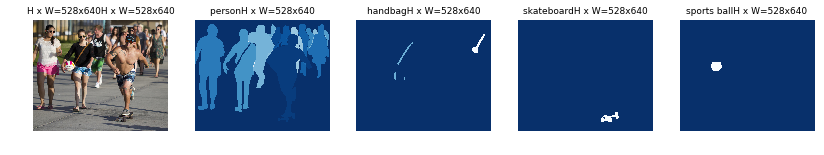

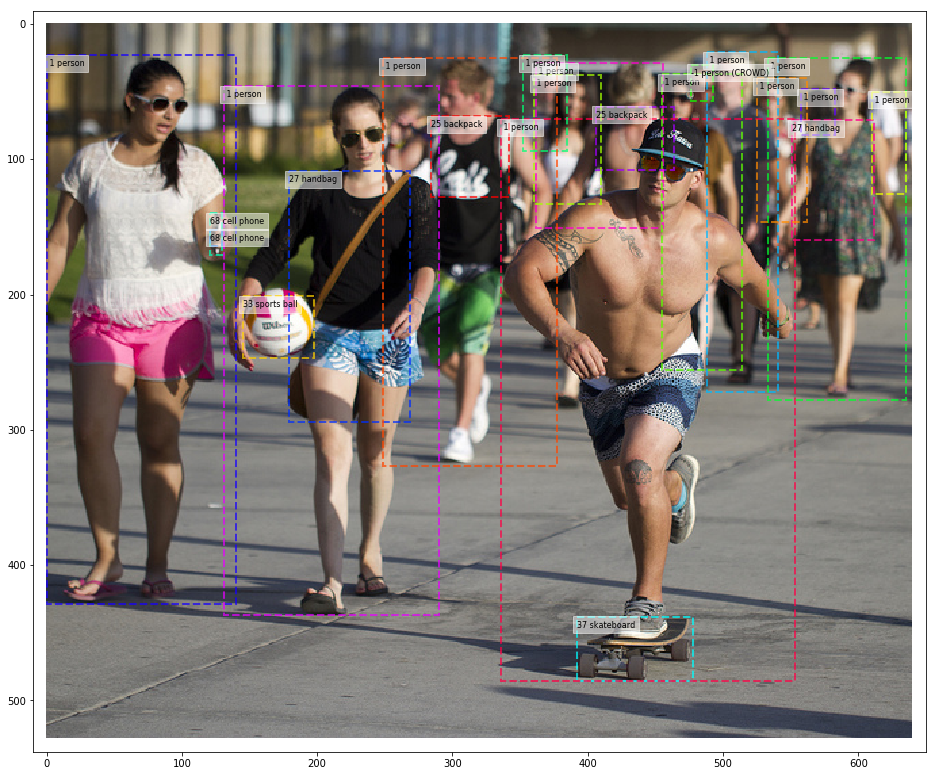

 Image_id    :  25735  Reference:  http://cocodataset.org/#explore?id=365305 Coco Id: 365305
 Image meta [25735   480   640     3   128     0   896  1024     1     1]
 Class ids   :  (2,)    [54 61]
 Class Names :  ['pizza', 'dining table']


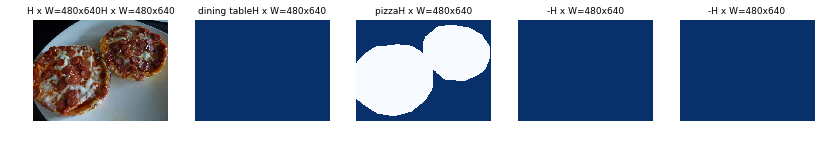

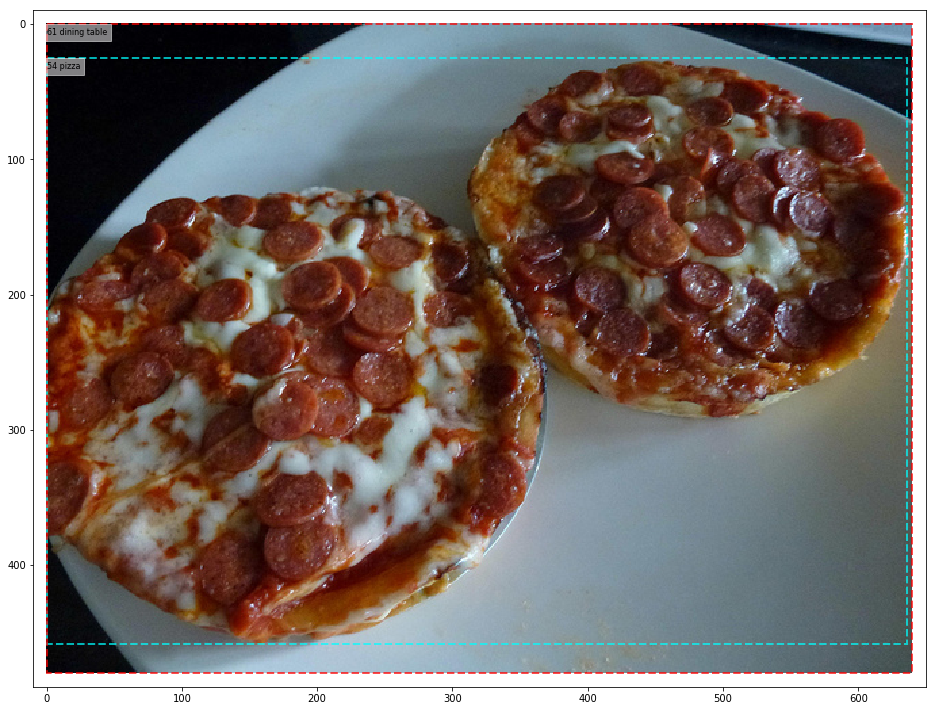

 Image_id    :  6467  Reference:  http://cocodataset.org/#explore?id=425114 Coco Id: 425114
 Image meta [6467  426  640    3  171    0  853 1024    1    1]
 Class ids   :  (37,)    [ 61   1   1  42  42  44  56  74  74  74   1   1  41  41  41  41  41  41  41  41  41  41  41  42
  57  57  61  61  74  74  74  41  57  57  41  74 -41]
 Class Names :  ['dining table', 'person', 'person', 'cup', 'cup', 'knife', 'cake', 'book', 'book', 'book', 'person', 'person', 'wine glass', 'wine glass', 'wine glass', 'wine glass', 'wine glass', 'wine glass', 'wine glass', 'wine glass', 'wine glass', 'wine glass', 'wine glass', 'cup', 'chair', 'chair', 'dining table', 'dining table', 'book', 'book', 'book', 'wine glass', 'chair', 'chair', 'wine glass', 'book', 'bottle']


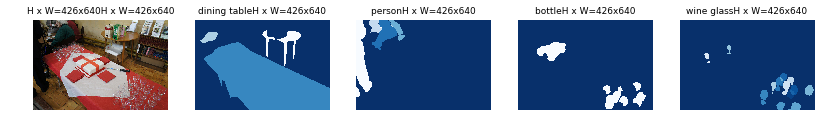

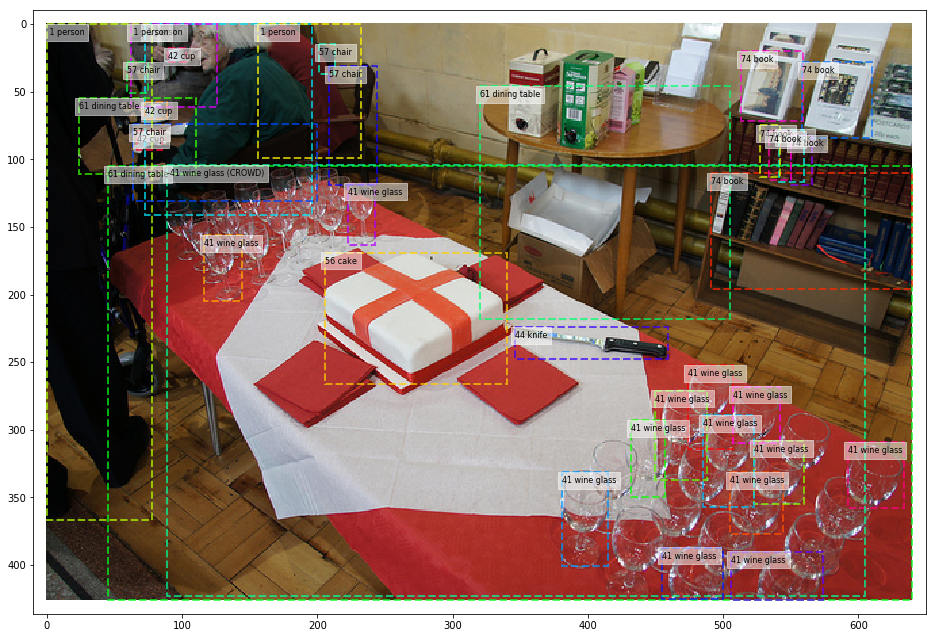

 Image_id    :  13167  Reference:  http://cocodataset.org/#explore?id=327392 Coco Id: 327392
 Image meta [13167   145   640     3   396     0   628  1024     1     1]
 Class ids   :  (22,)    [26 26 26 26 75 57 57  1  1 26 26 27 27 61  1  1  1  1  1 57 61 61]
 Class Names :  ['umbrella', 'umbrella', 'umbrella', 'umbrella', 'clock', 'chair', 'chair', 'person', 'person', 'umbrella', 'umbrella', 'handbag', 'handbag', 'dining table', 'person', 'person', 'person', 'person', 'person', 'chair', 'dining table', 'dining table']


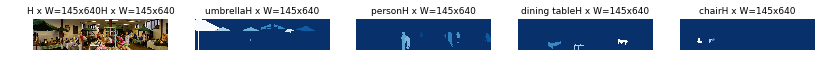

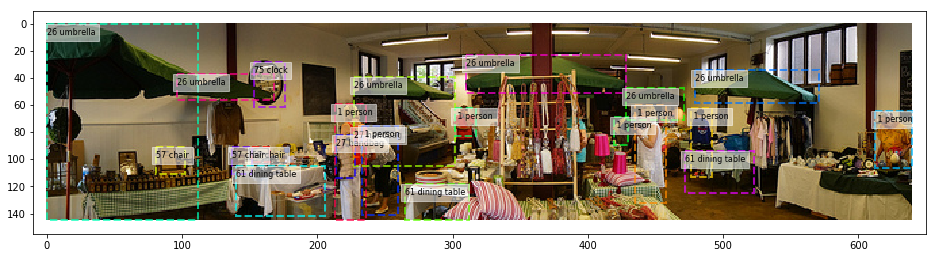

In [34]:
# batch_x, batch_y = next(generator)
IMAGE_LIST = batch_x[1][:,0]
print(IMAGE_LIST)
# IMAGE_LIST = [179, 180]
# batch_x, batch_y = data_gen_simulate(dataset, mrcnn_config, [179, 180, 181, 182])
display_training_batch(dataset, batch_x, masks = False)

In [35]:
print('IMAGE_LIST : ', IMAGE_LIST)
for image_id in IMAGE_LIST:
    print()
    print('IMAGE_ID : ', image_id)
    annotations = dataset.image_info[image_id]["annotations"]
#     print(annotations)
    for annotation in annotations:
        class_id = dataset.map_source_class_id( "coco.{}".format(annotation['category_id']))
        print("coco.id: {} --> class_id : {}  - {} ".format(annotation['category_id'],class_id, dataset.class_names[class_id]))

IMAGE_LIST :  [ 9146 25735  6467 13167]

IMAGE_ID :  9146
coco.id: 37 --> class_id : 33  - sports ball 
coco.id: 77 --> class_id : 68  - cell phone 
coco.id: 41 --> class_id : 37  - skateboard 
coco.id: 27 --> class_id : 25  - backpack 
coco.id: 31 --> class_id : 27  - handbag 
coco.id: 31 --> class_id : 27  - handbag 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 27 --> class_id : 25  - backpack 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 1 --> class_id : 1  - person 
coco.id: 77 --> class_id : 68  - cell phone 
coco.id: 1 --> class_id : 1  - person 

IMAGE_ID :  25735
coco.id: 59 --> class_id :

###  manipulate COCO object

In [ ]:
# coco = dataset.source_objs['train']

# loadCat = coco.loadCats()
# print('coco classes: ', type(loadCat), len(loadCat))
# pp.pprint(loadCat)

# coco_class_ids = []
# for source in dataset.source_objs:
#     print(source, dataset.source_objs[source])
#     src_coco = dataset.source_objs[source]
#     src_class_ids = sorted(src_coco.getCatIds())
#     coco_class_ids.extend(src_class_ids)
    
    
# print(type(coco_class_ids), len(coco_class_ids))    
# print(coco_class_ids)
# coco_class_ids = sorted(list(set(coco_class_ids)))
# print(type(coco_class_ids), len(coco_class_ids))    
# print(coco_class_ids)

####  add internal class id to `dataset.class_info` (has now been incorporated into `Dataset` code)

In [ ]:
# for cls_info in dataset.class_info:
#     print(cls_info)
#     source_key = cls_info['source']+'.'+str(cls_info['id'])
#     internal_id =  dataset.class_from_source_map[source_key]
#     print('{:25s}   external class id: {:3d}  internal id: {:3d}'.format(cls_info['name'], cls_info['id'], cls_info['internal_id']))
#     cls_info['internal_id'] = internal_id


#### build `category_to_class_map` (has now been incorporated into `Dataset` code)

In [19]:
# category_to_class_map = {}
# for i in dataset.class_info:
#     category_to_class_map.setdefault(i["category"],[]).append(i["internal_id"])
# #     print(i["category"], '   ',category_to_class_map[i["category"]])
# ttl = 0 
# for i in category_to_class_map.keys():
#     print('{:15s} {:4d}  {} '.format(i, len(category_to_class_map[i]) , category_to_class_map[i]))
#     ttl += len(category_to_class_map[i])
# print('Total classes: ', ttl)          

#### build `category_to_external_class_map` (has now been incorporated into `Dataset` code)

In [20]:
# category_to_external_class_map = {}
# for i in dataset.class_info:
#     category_to_external_class_map.setdefault(i["category"],[]).append(i["id"])
# #     print(i["category"], '   ',category_to_class_map[i["category"]])

# ttl = 0 
# for i in category_to_external_class_map.keys():
# #     print('{:15s} {:4d}  {}  \n       external {:4d}  {}'.format(i,
# #         len(category_to_class_map[i]) , category_to_class_map[i],len(category_to_external_class_map[i]) , category_to_external_class_map[i]))
#     print('{:15s} external {:4d}  {}'.format(i,
#         len(category_to_class_map[i]) , category_to_class_map[i],len(category_to_external_class_map[i]) , category_to_external_class_map[i]))
#     ttl += len(category_to_class_map[i])
# print('Total classes: ', ttl)          

## Build pairwise relation matrix

In [15]:
### Get ONLY COCO class ids 
# matrix_coco_ids = [i['internal_id']  for i in dataset.class_info if i['source'] == 'coco']
for i in dataset.active_class_ids:
    print(i, '  --> int_id:  ', dataset.ext_to_int_id[i])
print(dataset.active_class_ids)
 
 

62   --> int_id:   57
63   --> int_id:   58
67   --> int_id:   61
72   --> int_id:   63
73   --> int_id:   64
74   --> int_id:   65
75   --> int_id:   66
76   --> int_id:   67
77   --> int_id:   68
78   --> int_id:   69
79   --> int_id:   70
80   --> int_id:   71
81   --> int_id:   72
82   --> int_id:   73
[62, 63, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]


In [16]:
### Create pairwise matrix
matrix_class_ids = dataset.class_ids
num_classes = len(matrix_class_ids)


pairwise_matrix = np.zeros((num_classes+1,num_classes+1))
pairwise_list = []
row = 1
for i in matrix_class_ids:  
    current_row = [0]
    class_pairwise_list = []
    for  j in matrix_class_ids:
        i_coco_id = dataset.int_to_ext_id[i]
        j_coco_id = dataset.int_to_ext_id[j]
        imgCount = 0
        for source in dataset.source_objs:
            src_coco = dataset.source_objs[source]
            imgCount += len(src_coco.getImgIds(catIds=[i_coco_id,j_coco_id]))            
#         print('coco classes: ', cls, type(imgIds), len(imgIds))
#         print( ' {:2d}  [{:2d}] {:12s}-{:20s}    {:2d}  [{:2d}] {:12s}-{:20s}    number of images: {:5d}'.format(
#                  i, i_coco_id,  dataset.class_info[i]['category'], dataset.class_names[i], j, j_coco_id, dataset.class_info[j]['category'],dataset.class_names[j],imgCount))
        class_pairwise_list.append({
                    "id":j,
                    "external_id": j_coco_id,
                    "name":dataset.class_names[j], 
                    "category": dataset.class_info[j]['category'], 
                    "img_count": imgCount })
        current_row.append(imgCount)
        
    pairwise_list.append((i,class_pairwise_list))
    pairwise_matrix[row] = current_row
    row += 1

print(len(pairwise_list))

81


#### used if we create separate pairwise matrices for eeach coco source

In [18]:
np.set_printoptions(linewidth=200,precision=4,threshold=10000, suppress = True)
# print(pairwise_matrices["train"][69:75,69:75])
# print(pairwise_matrices["val35k"][69:75,69:75])
# pairwise_matrix_all = np.zeros((num_classes+1,num_classes+1))
# for source in dataset.source_objs:
#     pairwise_matrix_all += pairwise_matrices[source]
print(type(pairwise_list), len(pairwise_list), len(pairwise_list[0]), len(pairwise_list[0][1]))
pp.pprint(pairwise_list[0])
print(pairwise_matrix.shape)

<class 'list'> 81 2 81
( 0,
  [ {'category': 'background', 'external_id': 0, 'id': 0, 'img_count': 0, 'name': 'BG'},
    {'category': 'person', 'external_id': 1, 'id': 1, 'img_count': 0, 'name': 'person'},
    {'category': 'vehicle', 'external_id': 2, 'id': 2, 'img_count': 0, 'name': 'bicycle'},
    {'category': 'vehicle', 'external_id': 3, 'id': 3, 'img_count': 0, 'name': 'car'},
    {'category': 'vehicle', 'external_id': 4, 'id': 4, 'img_count': 0, 'name': 'motorcycle'},
    {'category': 'vehicle', 'external_id': 5, 'id': 5, 'img_count': 0, 'name': 'airplane'},
    {'category': 'vehicle', 'external_id': 6, 'id': 6, 'img_count': 0, 'name': 'bus'},
    {'category': 'vehicle', 'external_id': 7, 'id': 7, 'img_count': 0, 'name': 'train'},
    {'category': 'vehicle', 'external_id': 8, 'id': 8, 'img_count': 0, 'name': 'truck'},
    {'category': 'vehicle', 'external_id': 9, 'id': 9, 'img_count': 0, 'name': 'boat'},
    {'category': 'outdoor', 'external_id': 10, 'id': 10, 'img_count': 0, 'nam

In [19]:
print(pairwise_matrix.shape)

(82, 82)


####  Display pairwise counts for a given class ( id is index into `pairwise_list`)

In [20]:
print(pairwise_matrix[69:75,69:75])    

[[4803.   41.   52.    5.   94.   76.]
 [  41. 1547.  903.   97.  668.  682.]
 [  52.  903. 2877.  124. 1168. 1023.]
 [   5.   97.  124.  217.  116.   78.]
 [  94.  668. 1168.  116. 4678.  807.]
 [  76.  682. 1023.   78.  807. 2360.]]


#### display pairwise relations for a given coco class

In [22]:
from operator import itemgetter
id = 1
cls_id = pairwise_list[id][0]
cls_name = dataset.class_names[cls_id]

sortedlist = sorted(pairwise_list[id][1], key=itemgetter('category','img_count'), reverse=True) 
print(type(sortedlist))
print(cls_id, '-' , cls_name)
for item in sortedlist:
    print( ' {:2d} ({:2d}), {:12s},{:20s} count: {:5d}'.format(
             item["id"],item["external_id"] ,item["category"], item["name"] , item["img_count"]))


<class 'list'>
1 - person
  3 ( 3), vehicle     ,car                  count:  8519
  8 ( 8), vehicle     ,truck                count:  3992
  6 ( 6), vehicle     ,bus                  count:  3011
  4 ( 4), vehicle     ,motorcycle           count:  2786
  2 ( 2), vehicle     ,bicycle              count:  2643
  9 ( 9), vehicle     ,boat                 count:  1987
  7 ( 7), vehicle     ,train                count:  1627
  5 ( 5), vehicle     ,airplane             count:  1027
 33 (37), sports      ,sports ball          count:  4097
 37 (41), sports      ,skateboard           count:  3417
 38 (42), sports      ,surfboard            count:  3365
 39 (43), sports      ,tennis racket        count:  3361
 31 (35), sports      ,skis                 count:  3044
 36 (40), sports      ,baseball glove       count:  2602
 35 (39), sports      ,baseball bat         count:  2477
 34 (38), sports      ,kite                 count:  2099
 30 (34), sports      ,frisbee              count:  1821
 32 (

## Display pairwise counts

### `display_pairwise_heatmap` routine

In [23]:
import matplotlib.pyplot as plt
def display_pairwise_heatmap(show_matrix, show_labels, category, colormap = cm.coolwarm):
    # show_labels = labels[1:10]
    num_classes = len(show_labels)
    #     print(' num classes: ', num_classes, 'matrix shape: ',show_matrix.shape)
     
    fig, ax = plt.subplots(1,1,figsize=(num_classes,num_classes))
    im = ax.imshow(show_matrix, cmap=colormap)
    # cmap=cm.bone, #  cmap=cm.Dark2 # cmap = cm.coolwarm   # cmap=cm.YlOrRd
    # We want to show all ticks...
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(show_labels, size = 9)
    ax.set_yticklabels(show_labels, size = 9)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, show_matrix[i, j],  
                           ha="center", va="center", color="w")            
#             if i != j:
#                 text = ax.text(j, i, show_matrix[i, j],  
#                            ha="center", va="center", color="w")
#             else:
#                 text = ax.text(j, i, ' --',  
#                            ha="center", va="center", color="w")

    ax.set_title("pairwise relations"+category.upper())
    # fig.tight_layout()
    plt.show()
    return  fig



####  For a given category, get class_ids from `category_to_class_map`, and display heatmap 

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]


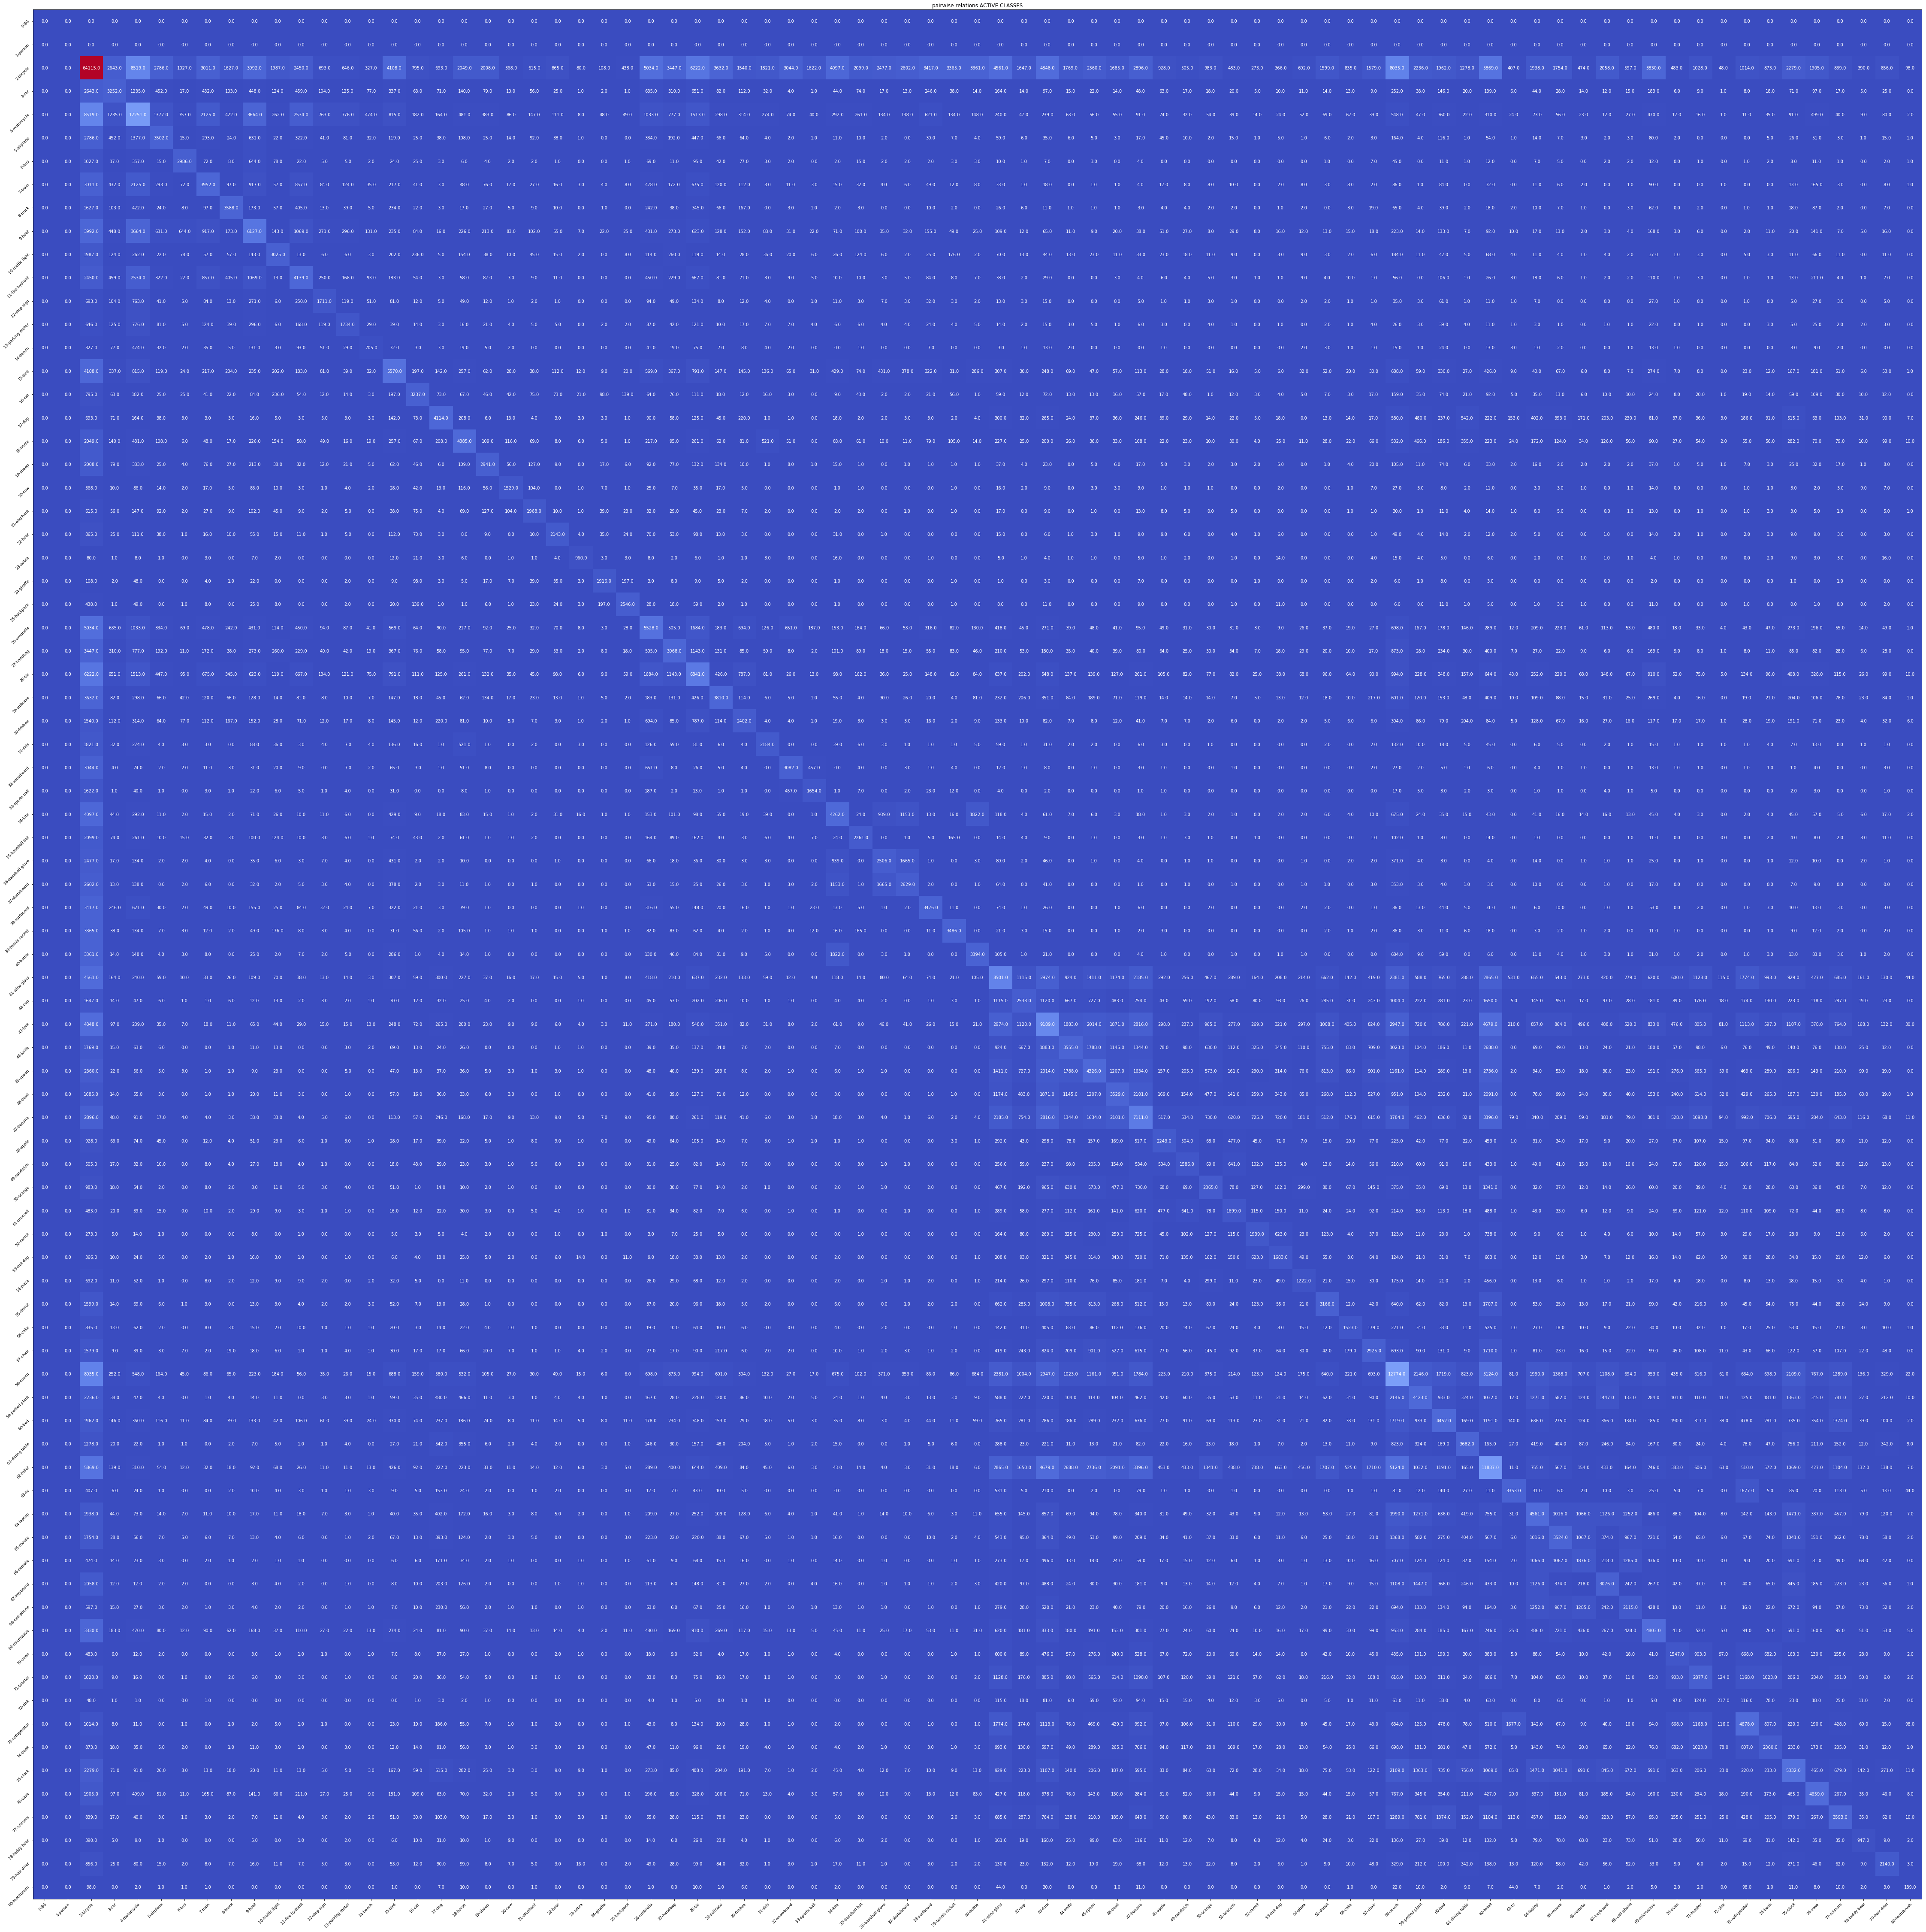

In [72]:
indices = []
external_indices = []
category_ttl = ''
show_class_ids = dataset.class_ids ## [57, 58, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]
print(show_class_ids)
show_labels = [str(index)+'-'+dataset.class_names[index] for index in show_class_ids]
show_matrix = (pairwise_matrix[show_class_ids])[:,show_class_ids]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, ' ACTIVE CLASSES')

In [73]:
hmfig.savefig("E:\\Users\\Kevin.Bardool\\Desktop\\NN Related files\\ALL_CLASSES")

###  For a given category, get class_ids from `category_to_class_map`, and display heatmap 

(82, 82)
   person 1 matrix shape (1, 1)
   indices: [1] labels:  ['1(1)-person']


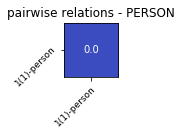

   food 10 matrix shape (10, 10)
   indices: [47, 48, 49, 50, 51, 52, 53, 54, 55, 56] labels:  ['47(52)-banana', '48(53)-apple', '49(54)-sandwich', '50(55)-orange', '51(56)-broccoli', '52(57)-carrot', '53(58)-hot dog', '54(59)-pizza', '55(60)-donut', '56(61)-cake']


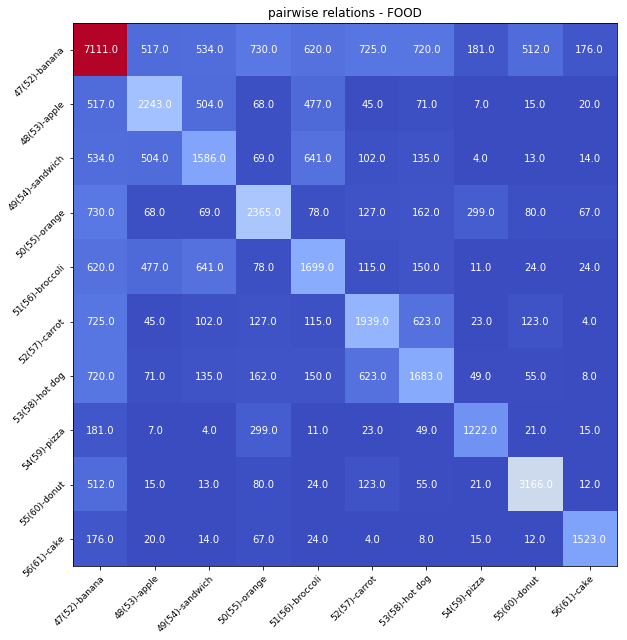

   indoor 7 matrix shape (7, 7)
   indices: [74, 75, 76, 77, 78, 79, 80] labels:  ['74(84)-book', '75(85)-clock', '76(86)-vase', '77(87)-scissors', '78(88)-teddy bear', '79(89)-hair drier', '80(90)-toothbrush']


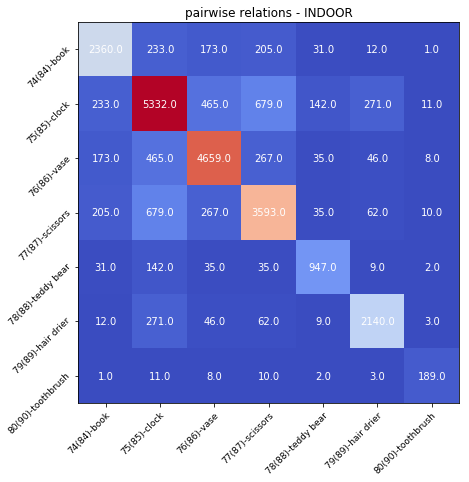

   accessory 5 matrix shape (5, 5)
   indices: [25, 26, 27, 28, 29] labels:  ['25(27)-backpack', '26(28)-umbrella', '27(31)-handbag', '28(32)-tie', '29(33)-suitcase']


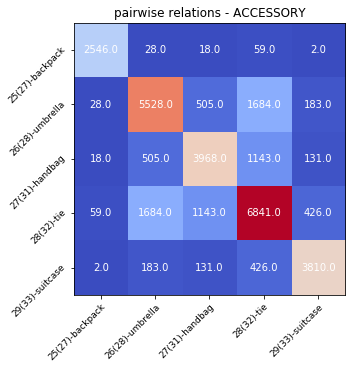

   outdoor 5 matrix shape (5, 5)
   indices: [10, 11, 12, 13, 14] labels:  ['10(10)-traffic light', '11(11)-fire hydrant', '12(13)-stop sign', '13(14)-parking meter', '14(15)-bench']


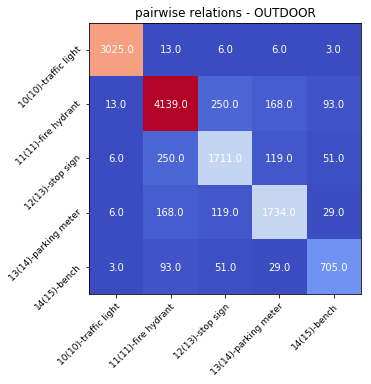

   kitchen 7 matrix shape (7, 7)
   indices: [40, 41, 42, 43, 44, 45, 46] labels:  ['40(44)-bottle', '41(46)-wine glass', '42(47)-cup', '43(48)-fork', '44(49)-knife', '45(50)-spoon', '46(51)-bowl']


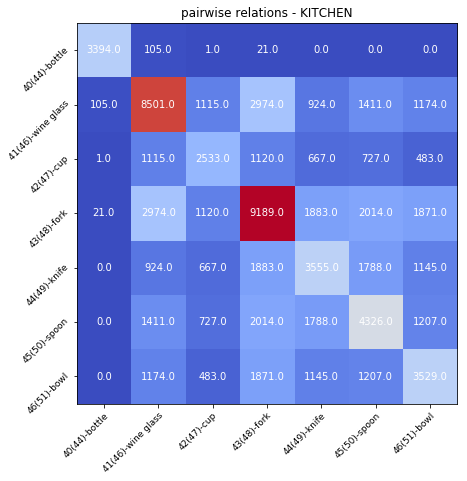

   vehicle 8 matrix shape (8, 8)
   indices: [2, 3, 4, 5, 6, 7, 8, 9] labels:  ['2(2)-bicycle', '3(3)-car', '4(4)-motorcycle', '5(5)-airplane', '6(6)-bus', '7(7)-train', '8(8)-truck', '9(9)-boat']


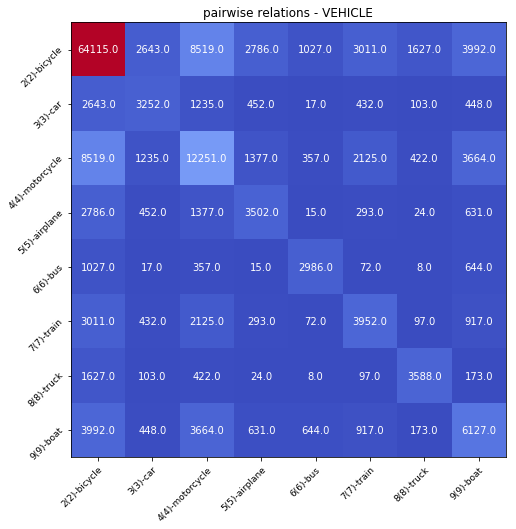

   animal 10 matrix shape (10, 10)
   indices: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24] labels:  ['15(16)-bird', '16(17)-cat', '17(18)-dog', '18(19)-horse', '19(20)-sheep', '20(21)-cow', '21(22)-elephant', '22(23)-bear', '23(24)-zebra', '24(25)-giraffe']


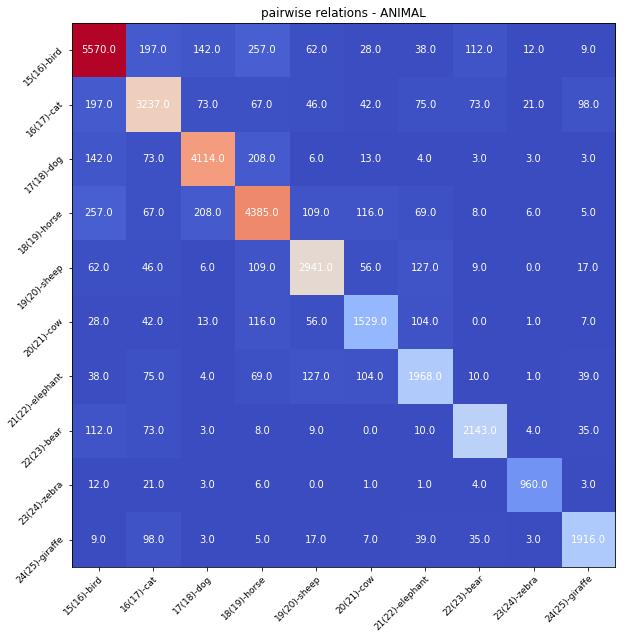

   appliance 5 matrix shape (5, 5)
   indices: [69, 70, 71, 72, 73] labels:  ['69(78)-microwave', '70(79)-oven', '71(80)-toaster', '72(81)-sink', '73(82)-refrigerator']


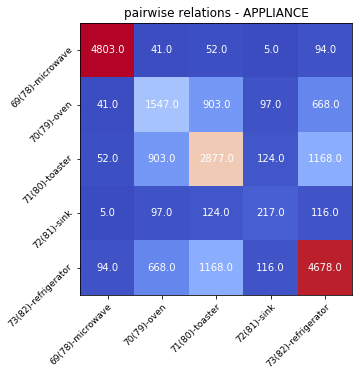

   electronic 6 matrix shape (6, 6)
   indices: [63, 64, 65, 66, 67, 68] labels:  ['63(72)-tv', '64(73)-laptop', '65(74)-mouse', '66(75)-remote', '67(76)-keyboard', '68(77)-cell phone']


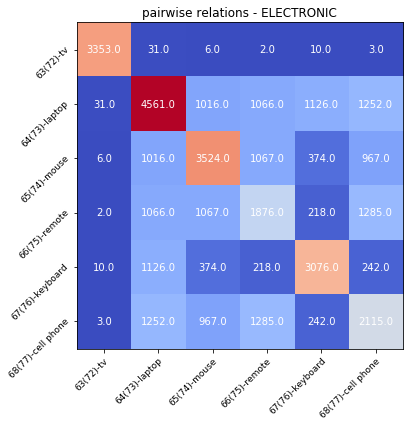

   sports 10 matrix shape (10, 10)
   indices: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39] labels:  ['30(34)-frisbee', '31(35)-skis', '32(36)-snowboard', '33(37)-sports ball', '34(38)-kite', '35(39)-baseball bat', '36(40)-baseball glove', '37(41)-skateboard', '38(42)-surfboard', '39(43)-tennis racket']


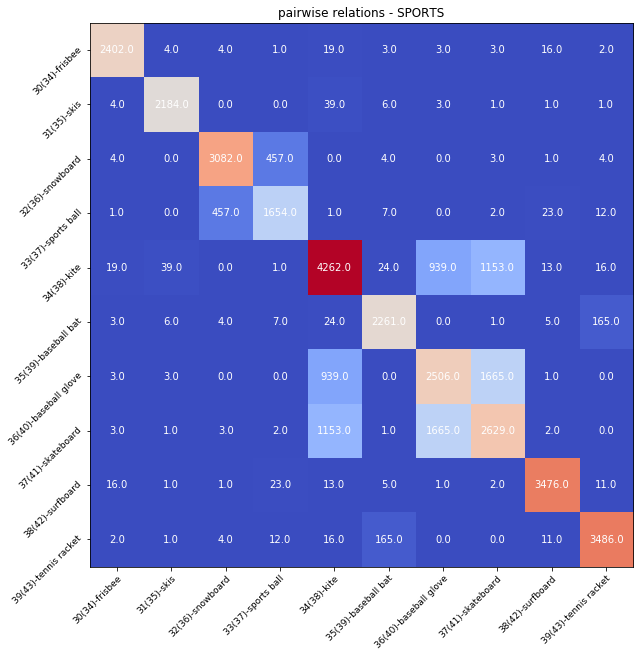

   furniture 6 matrix shape (6, 6)
   indices: [57, 58, 59, 60, 61, 62] labels:  ['57(62)-chair', '58(63)-couch', '59(64)-potted plant', '60(65)-bed', '61(67)-dining table', '62(70)-toilet']


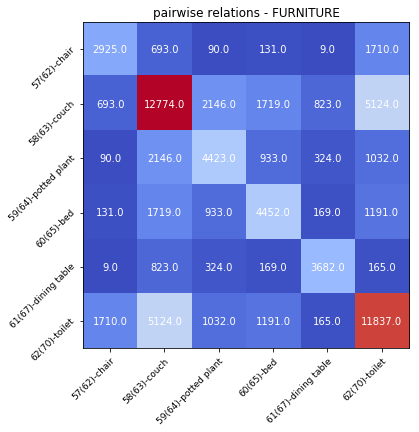

In [24]:
# fig = plt.figure(figsize=(20,20))
print(pairwise_matrix.shape)
for category in dataset.category_to_class_map:   #category_to_class_map:
    if category == 'background':
         continue
    indices = dataset.category_to_class_map[category]
    ext_indices = dataset.category_to_external_class_map[category]
    show_labels = [str(idx)+'('+str(ext_idx)+')-'+dataset.class_names[idx] for idx, ext_idx in zip(indices, ext_indices)]
    show_matrix = (pairwise_matrix[indices])[:,indices]
    
#     for i in range(show_matrix.shape[0]):
#         show_matrix[i,i] = 0
    print( '  ',category, len(indices), 'matrix shape',show_matrix.shape)
    print( '   indices:',indices, 'labels: ', show_labels)
    category_ttl = ' - '+category
    hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl, cm.coolwarm)
#     hmfig.savefig("E:\\Users\\Kevin.Bardool\\Desktop\\NN Related files\\"+category_ttl)

####  FURNITURE - ELECTRONIC

furniture     [57, 58, 59, 60, 61, 62]
electronic     [63, 64, 65, 66, 67, 68]


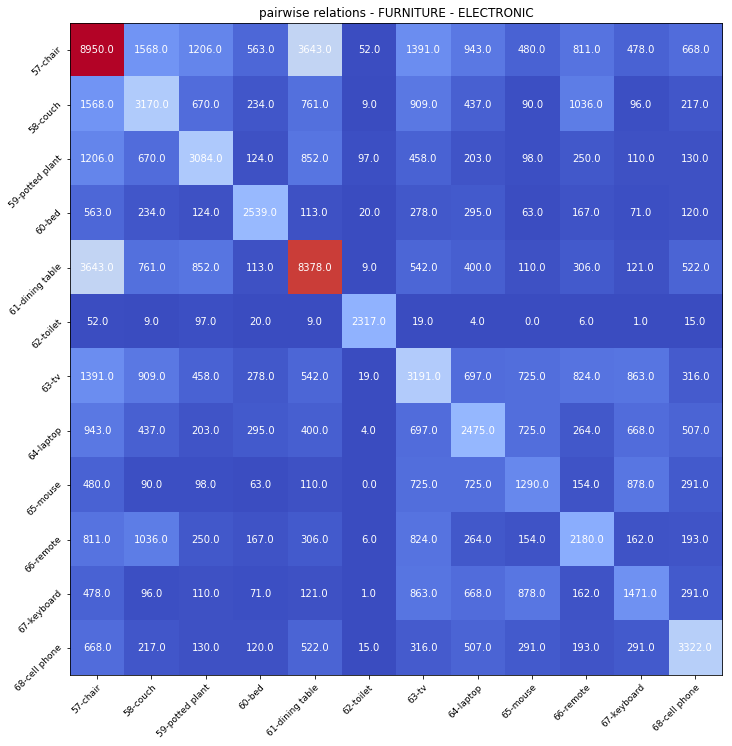

In [91]:
indices = []
external_indices = []
category_ttl = ''

for category in ['furniture',  'electronic' ]:   #category_to_class_map:
    print(category, '   ', category_to_class_map[category])
    indices.extend(category_to_class_map[category])
    external_indices.extend(category_to_external_class_map[category])
#     print(' indices after adding ',category, '   ', indices)
    category_ttl += ' - '+category
show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)

#### FURNITURE-FOOD

furniture     [57, 58, 59, 60, 61, 62]
food     [47, 48, 49, 50, 51, 52, 53, 54, 55, 56]


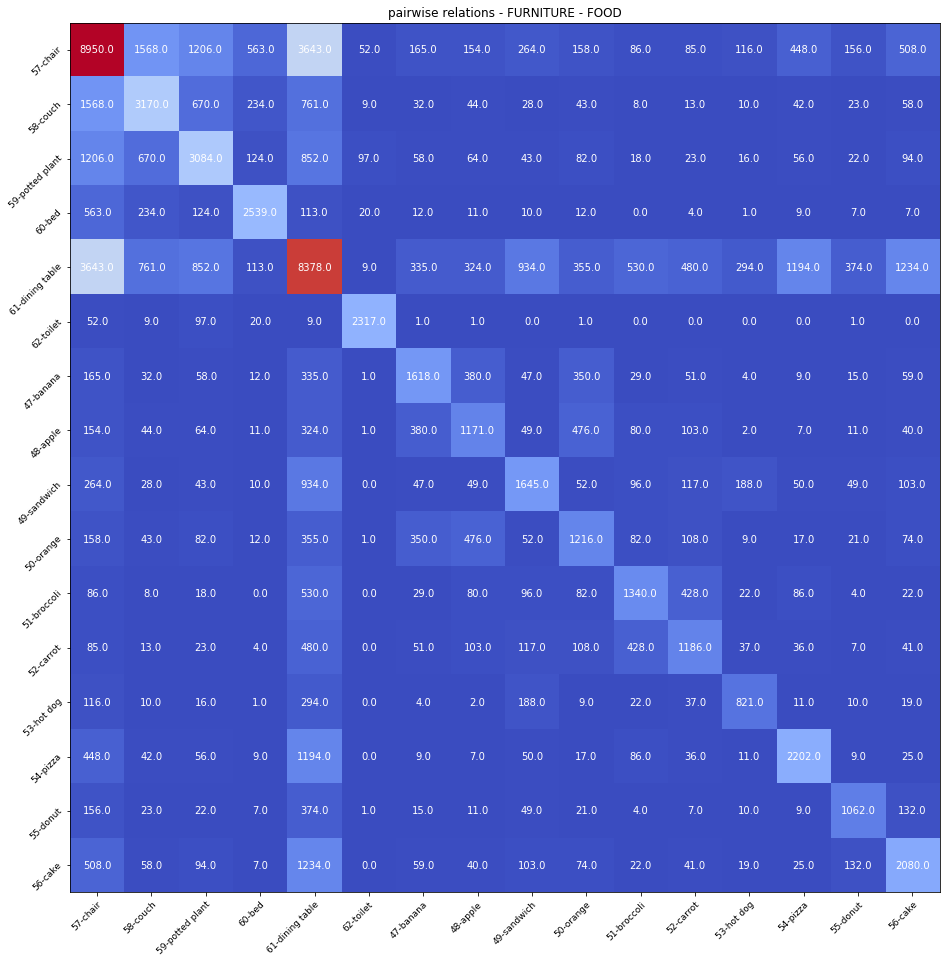

In [92]:
indices = []
external_indices = []
category_ttl = ''

for category in ['furniture',  'food' ]:   #category_to_class_map:
    print(category, '   ', category_to_class_map[category])
    indices.extend(category_to_class_map[category])
    external_indices.extend(category_to_external_class_map[category])
#     print(' indices after adding ',category, '   ', indices)
    category_ttl += ' - '+category
show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)

#### FURNITURE-INDOOR

furniture     [57, 58, 59, 60, 61, 62]
indoor     [74, 75, 76, 77, 78, 79, 80]


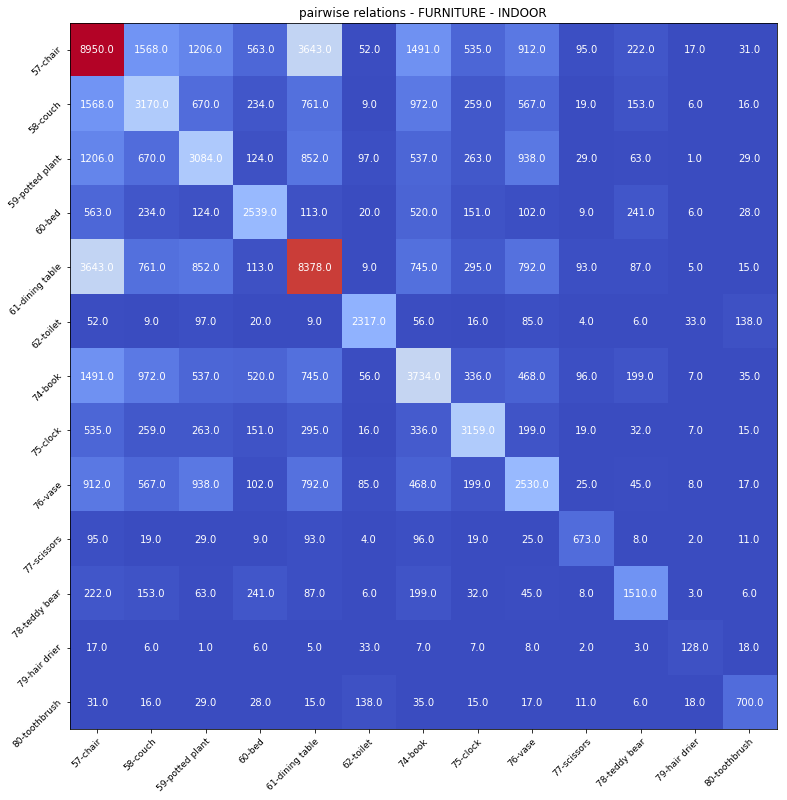

In [93]:
indices = []
external_indices = []
category_ttl = ''

for category in ['furniture',  'indoor' ]:   #category_to_class_map:
    print(category, '   ', category_to_class_map[category])
    indices.extend(category_to_class_map[category])
    external_indices.extend(category_to_external_class_map[category])
#     print(' indices after adding ',category, '   ', indices)
    category_ttl += ' - '+category
show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)

#### APPLIANCE - KITCHEN - SPORTS

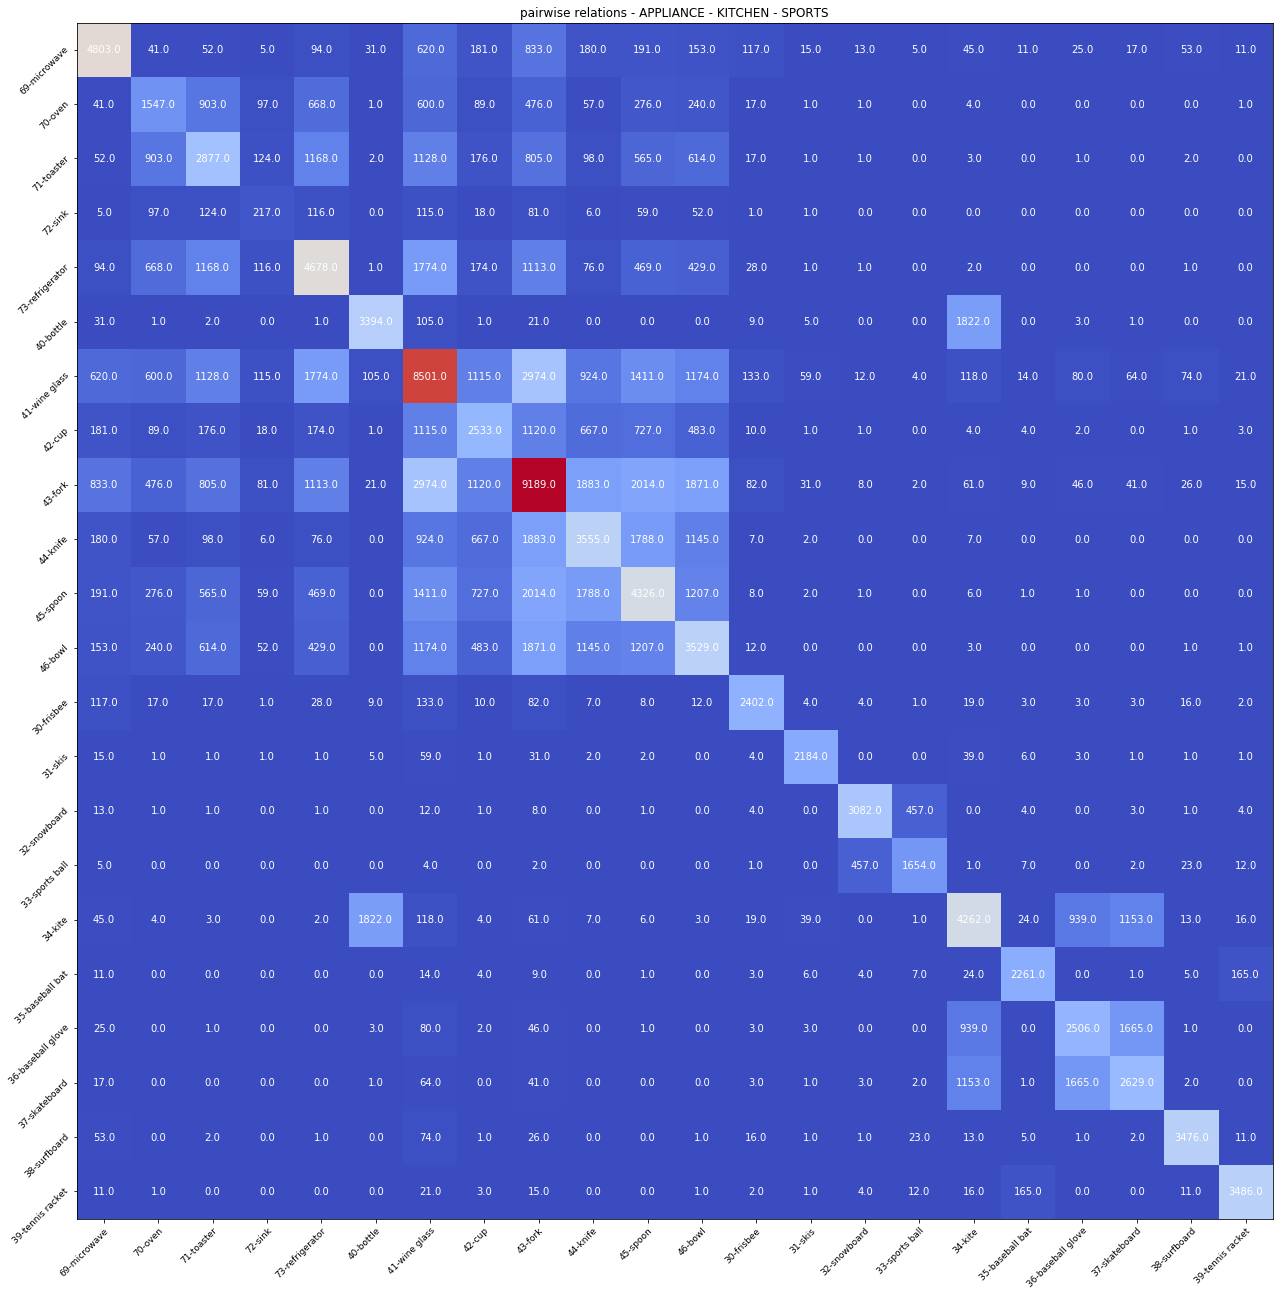

In [76]:
indices = []
external_indices = []
category_ttl = ''
for category in ['appliance',  'kitchen' , 'sports']:   #category_to_class_map:
#     print(category, '   ', category_to_class_map[category])
    indices.extend(dataset.category_to_class_map[category])
    external_indices.extend(dataset.category_to_external_class_map[category])
    category_ttl += ' - '+category

show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)
# hmfig.savefig("E:\\Users\\Kevin.Bardool\\Desktop\\NN Related files\\"+category_ttl)

#### APPLIANCE - KITCHEN - OUTDOOR

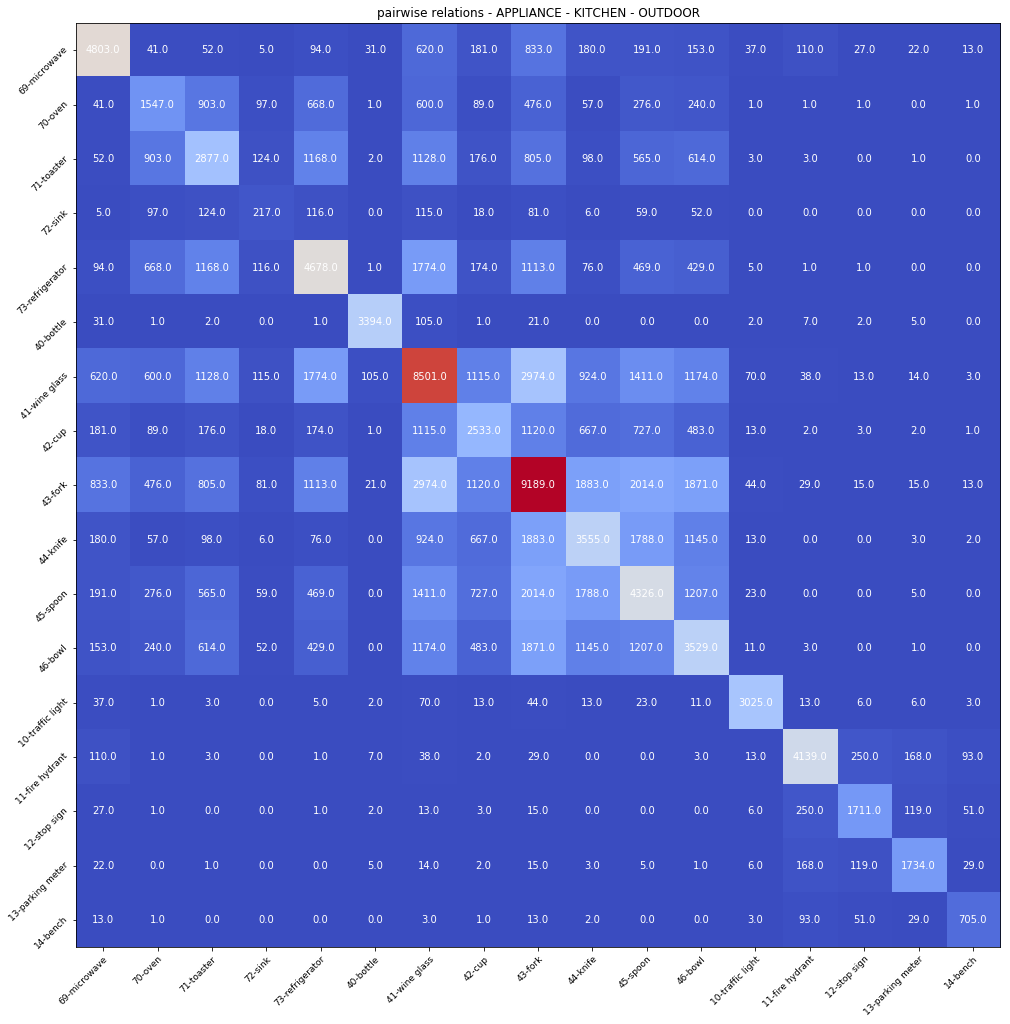

In [79]:
indices = []
external_indices = []
category_ttl = ''

for category in ['appliance',  'kitchen' , 'outdoor']:   #category_to_class_map:
#     print(category, '   ', category_to_class_map[category])
    indices.extend(dataset.category_to_class_map[category])
    external_indices.extend(dataset.category_to_external_class_map[category])
    category_ttl += ' - '+category

show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)
# hmfig.savefig("E:\\Users\\Kevin.Bardool\\Desktop\\NN Related files\\"+category_ttl)

####  APPLIANCE - KITCHEN - FURNITURE

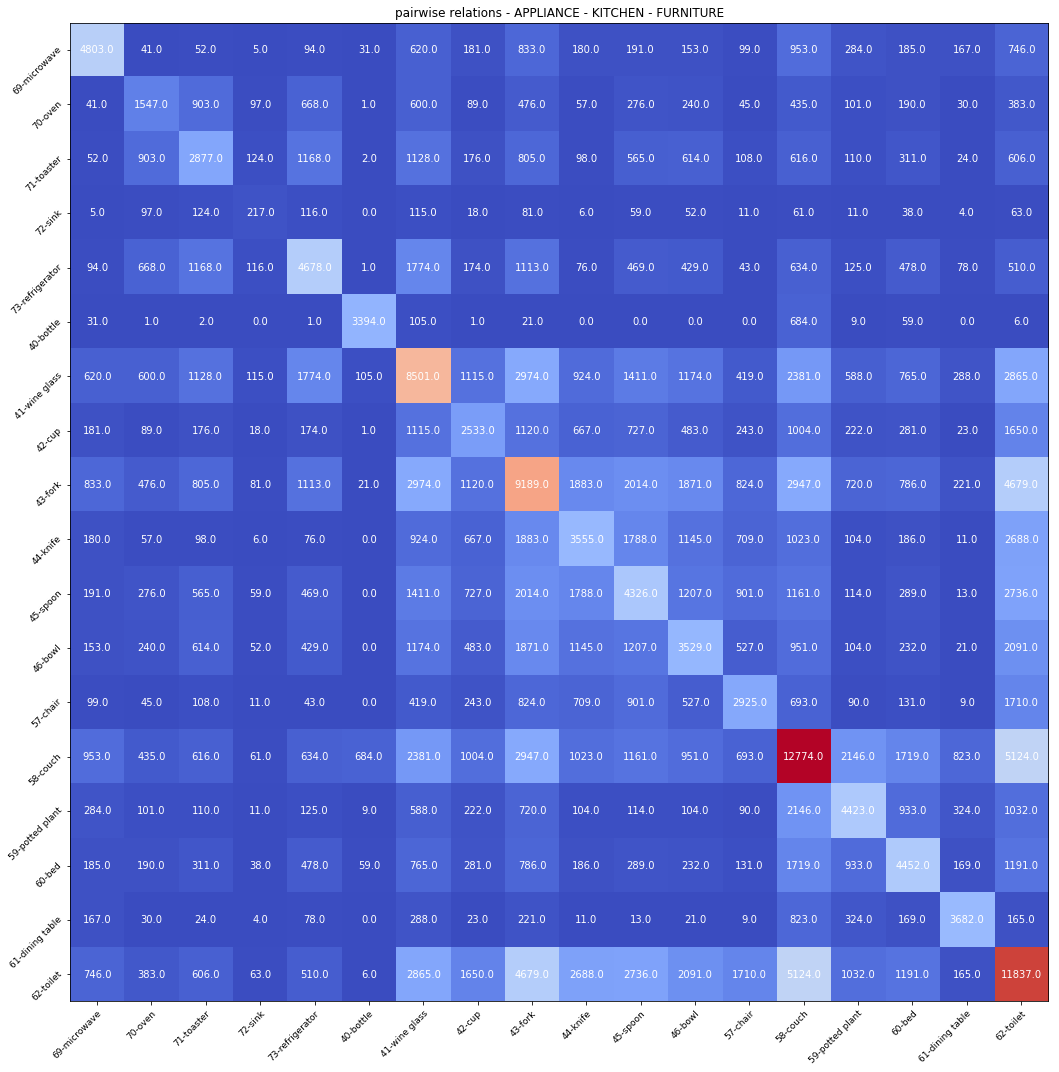

In [25]:
indices = []
external_indices = []
category_ttl = ''

for category in ['appliance',  'kitchen' , 'furniture']:   #category_to_class_map:
#     print(category, '   ', category_to_class_map[category])
    indices.extend(dataset.category_to_class_map[category])
    external_indices.extend(dataset.category_to_external_class_map[category])
    category_ttl += ' - '+category

show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)
# hmfig.savefig("E:\\Users\\Kevin.Bardool\\Desktop\\NN Related files\\"+category_ttl)

In [11]:
indices = []
external_indices = []
category_ttl = ''

for category in ['furniture',  'electronic' ]:   #category_to_class_map:
    print(category, '   ', category_to_class_map[category])
    indices.extend(category_to_class_map[category])
    external_indices.extend(category_to_external_class_map[category])
#     print(' indices after adding ',category, '   ', indices)
    category_ttl += ' - '+category
show_labels = [str(index)+'-'+dataset.class_names[index] for index in indices]
show_matrix = (pairwise_matrix[indices])[:,indices]
hmfig = display_pairwise_heatmap(show_matrix, show_labels, category_ttl)

NameError: name 'category_to_class_map' is not defined

## HeatmapDataset

In [ ]:
HEATMAP_PATH = os.path.join(paths.DIR_DATASET,'coco2014_heatmaps')
print(HEATMAP_PATH)
from mrcnn.heatmap import HeatmapDataset
dataset = HeatmapDataset()

In [ ]:
dataset.load_heatmap(mrcnn_config.COCO_DATASET_PATH, HEATMAP_PATH, 'minival')
# def load_heatmap(self, dataset_dir, heatmap_dataset_dir, subset, class_ids=None,class_map=None, return_coco=False):
dataset.prepare()

#### simulate `load_heatmap()`

In [ ]:
dataset_dir =mrcnn_config.COCO_DATASET_PATH
heatmap_dataset_dir = HEATMAP_PATH
subset = 'minival'
class_ids=None
class_map=None
return_coco=False

In [ ]:
image_dir = os.path.join(dataset_dir, "train2014" if subset == "train" else "val2014")
heatmap_dir = os.path.join(heatmap_dataset_dir, "train2014" if subset == "train" else "val2014")
#       image_dir = os.path.join(dataset_dir, "train2017" if subset == "train" lse "val2017")
print(image_dir,'\n', heatmap_dir)
 
# Create COCO object
json_path_dict = {
    "train"  :  "annotations/instances_train2014.json",
    "val"    :  "annotations/instances_val2014.json",
    "minival":  "annotations/instances_minival2014.json",
    "val35k" :  "annotations/instances_valminusminival2014.json",
    "test"   :  "annotations/image_info_test2014.json"
}
print('subset: ', subset, 'json_path_dir: ', json_path_dict[subset])
coco = COCO(os.path.join(dataset_dir, json_path_dict[subset]))

In [ ]:
# Load all classes or a subset?
if not class_ids:
    # All classes
    class_ids = sorted(coco.getCatIds())
print(' ClassIds     :', class_ids)

In [ ]:
##--------------------------------------------------------------
## Get image ids - using COCO
##--------------------------------------------------------------
#All images or a subset?
if class_ids:
    print(' Subset of classes')
    image_ids = []
    for id in class_ids:
        image_ids.extend(list(coco.getImgIds(catIds=[id])))
    # Remove duplicates
    image_ids = list(set(image_ids))
else:
    # All images
    class_ids = sorted(coco.getCatIds())
    print(' All classes')    
    image_ids = list(coco.imgs.keys())
    
print(' ClassIds     : ', len(class_ids))
print(' Image ids    : ', len(image_ids))

In [ ]:
# # Add classes to dataset.class_info structure
for i in class_ids:
    dataset.add_class("coco", i, coco.loadCats(i)[0]["name"])

In [ ]:
len(dataset.class_info)
# image_ids[:20]

In [ ]:
# # print(' ClassIds     :', class_ids)
# # Add images to dataset.image_info structure
dataset.image_info = []
heatmap_notfound=  heatmap_found = 0
print(heatmap_notfound, heatmap_found)
for i in image_ids:
    print('image id: ',i)
    heatmap_filename = 'hm_{:012d}.npz'.format(i)
    heatmap_path = os.path.join(heatmap_dir, heatmap_filename) 
    
    ## Only load image_info data structure for images where the corrsponding 
    ## heatmap .npz file exist
    if not os.path.isfile(heatmap_path):
        print('file not found:::',heatmap_filename)
        heatmap_notfound += 1
    else:
        dataset.add_image(
            "coco", image_id=i,
            path=os.path.join(image_dir, coco.imgs[i]['file_name']),
            width=coco.imgs[i]["width"],
            height=coco.imgs[i]["height"],
            heatmap_path=heatmap_path
          )
        heatmap_found += 1
        # annotations=coco.loadAnns(coco.getAnnIds(imgIds=[i], catIds=class_ids, iscrowd=None)))
        
        
print(' Images ids :', len(image_ids))
print('    Corresponding heatmap found     :' , heatmap_found)
print('    Corresponding heatmap not found :' , heatmap_notfound)
print(' Total      :', heatmap_found + heatmap_notfound)

In [ ]:
print(len(dataset.image_ids))
print(len(dataset.image_info))
print(dataset.image_info[0])
# print(dataset.image_info[5000])

In [ ]:
##--------------------------------------------------------------
## Get image ids - using walk on HEATMAP_PATH
##--------------------------------------------------------------
print(' image dir        : ', image_dir) 
print(' json_path_dir    : ', os.path.join(dataset_dir, json_path_dict[subset]))
regex = re.compile(".*/\w+(\d{12})\.jpg")


image_ids = [] 
heatmap_files = next(os.walk(heatmap_dir))[2]
print('heat ap dir :' , heatmap_dir)

In [ ]:
for hm_file in heatmap_files:
    print(' Processing file: ', hm_file)
    heatmap_path=os.path.join(heatmap_dir, hm_file) 
    i = int(os.path.splitext(hm_file.lstrip('hm_'))[0])
    loaddata = np.load(heatmap_path)
    print(loaddata['coco_info'])
    coco_id = loaddata['coco_info'][0]
    coco_filename = loaddata['coco_info'][1]
    input_image_meta = loaddata['input_image_meta']
    loaddata.close()
    dataset.add_image(
        "coco", 
        image_id=i,
        path=os.path.join(image_dir, coco.imgs[i]['file_name']),
        width=coco.imgs[i]["width"],
        height=coco.imgs[i]["height"],
        heatmap_path=os.path.join(heatmap_dir, 'hm_{:012d}'.format(i)) 
      )    
#     print(input_filename, type(input_filename), len(input_filename))
#     coco_filename = input_filename.replace('\\' , "/")
#     print(coco_filename)
#     regex_match  = regex.match(input_filename)            
#     # Add images to dataset.image_info structure
#     if regex_match:
#         coco_id = int(regex_match.group(1))
#     print(i, input_image_meta[:8],' ', input_filename, ' coco_id : ',coco_id)

#     self.add_image(
#         "coco", 
#         image_id=i,
#         path = input_filename,
#         height=input_image_meta[1],
#         width= input_image_meta[2],
#         heatmap_path=heatmap_path
#       )
#     image_ids.append(i)
#         # annotations=coco.loadAnns(coco.getAnnIds(imgIds=[i], catIds=class_ids, iscrowd=None)))
# print(' number of images : ', len(image_ids))

#### Define data generator

In [ ]:
from mrcnn.datagen_fcn import fcn_data_generator, fcn_data_gen_simulate
##--------------------------------------------------------------------------------
## Data generators
##--------------------------------------------------------------------------------
generator = fcn_data_generator(dataset, mrcnn_config, shuffle=True,
                                 batch_size=mrcnn_config.BATCH_SIZE)
# val_generator   = data_generator(dataset_val, mrcnn_model.config, shuffle=True,
#                                  batch_size=mrcnn_config.BATCH_SIZE,
#                                  augment=False)

In [ ]:
train_batch_x, train_batch_y = next(generator)

for i in train_batch_x:
    print(type(i), i.shape, i.dtype)
for i in train_batch_y:
    print(type(i), i.shape)
print(train_batch_y)  

In [ ]:
# imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
from mrcnn.visualize import plot_2d_heatmap_compare
import mrcnn.utils as utils
# def plot_2d_heatmap_compare( Z1, Z2, boxes, image_idx, class_ids,  size = None, 
#                                  num_bboxes = 0, class_names=None, scale = 1,
#                                  title = '2D Comparison between 2d heatmaps w/ bboxes'):
train_batch_x, train_batch_y = fcn_data_gen_simulate(dataset, mrcnn_config, [210])
img_meta    = train_batch_x[1]
class_names = dataset.class_names
print(img_meta.shape)
for img_idx in range(mrcnn_config.BATCH_SIZE):
    print(img_meta[img_idx])
    image_id = img_meta[img_idx,0]
    image = dataset.load_image(image_id)
    timg  = train_batch_x[0][img_idx]
    print(' image from train_batch_x :', timg.shape, timg.dtype, np.min(timg), np.max(timg))
    print(' image from dataset load  :', image.shape, image.dtype, np.min(image), np.max(image))
    ## Display image, and mean-subtracted image
    visualize.display_image_bw(image)
#     visualize.display_images([image, train_batch_x[0][img_idx]], cols = 2, width = 18)
    
    ## display masks and bounding boxes
    mask, class_ids = dataset.load_mask(image_id)
    print('class_ids:', class_ids)
    bbox = utils.extract_bboxes(mask)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset.class_names, figsize =(8,8)) 
    

    ## display ground truth heatmaps
    gt_class_ids = np.unique(train_batch_x[5][img_idx,:,:,4]).astype(int).tolist()
    print('Image : {}  GT ClassIds: {}'.format(img_idx, gt_class_ids))
#     visualize.plot_2d_heatmap_no_bboxes(train_batch_x[4],img_idx, columns = 4, class_names=class_names)    
    visualize.plot_2d_heatmap_no_bboxes(train_batch_x[4], img_idx,class_ids = gt_class_ids, columns = 4, class_names=class_names)
    
    
    ## display predicted heatmaps
    pr_class_ids = np.unique(train_batch_x[3][img_idx,:,:,4]).astype(int).tolist()
    print('Image : {}  PR ClassIds: {}'.format(img_idx, pr_class_ids))
#     visualize.plot_2d_heatmap_no_bboxes(train_batch_x[2],img_idx, columns = 4, class_names=class_names)
    visualize.plot_2d_heatmap_no_bboxes(train_batch_x[2], img_idx,class_ids = gt_class_ids, columns = 4, class_names=class_names)
        

In [ ]:
from mrcnn.utils import unresize_image
from   matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import skimage.util
import skimage.io
paths.display()


In [ ]:
# ds = os.path.join(paths.COCO_DATASET_PATH,'val2014/COCO_val2014_000000017031.jpg')
ds = dataset.image_info[210]['path']
print(ds)
im = skimage.io.imread(ds)
print(im.shape, im.dtype, np.min(im), np.max(im))
# im = skimage.io.imread(ds)
# im = Image.open(ds)

In [ ]:
print('image    : ', image.shape, image.dtype)
image_bw = Image.fromarray(image).convert(mode='L')
# print('image_bw : ', image_bw.shape, image_bw.dtype)

molded_image, window, scale, padding = utils.resize_image(
    image,
    min_dim=mrcnn_config.IMAGE_MIN_DIM,
    max_dim=mrcnn_config.IMAGE_MAX_DIM,
    padding=mrcnn_config.IMAGE_PADDING)
print('molded_image   : ', molded_image.shape, molded_image.dtype)
print(' image meta    :', train_batch_x[1][0])

unresized_image = unresize_image(molded_image,train_batch_x[1][0])
print('unresized_image : ', unresized_image.shape, unmolded_image.dtype)

unresized_image_bw = np.asarray(Image.fromarray(unresized_image).convert(mode='L'))
print('unresized_image_bw: ',unresized_image_bw.shape, unresized_image_bw.dtype)


unmolded_image = utils.unmold_image(molded_image, mrcnn_config)
print('unmolded_image : ', unmolded_image.shape, unmolded_image.dtype)

unmolded_image_bw = np.asarray(Image.fromarray(unmolded_image).convert(mode='L'))
print('unmolded_image_bw : ', unmolded_image_bw.shape, unmolded_image_bw.dtype)


unmolded_heatmap = unresize_image(train_batch_x[2][0,:,:,24],train_batch_x[1][0], upscale = mrcnn_config.HEATMAP_SCALE_FACTOR)
print('unmolded_heatmap : ', unmolded_heatmap.shape, unmolded_heatmap.dtype)


print(train_batch_x[2][0,:,:,24].dtype)




In [ ]:
import matplotlib.pyplot as plt
print('Orig image shape: ', image.shape)
print('Image window is : ', window)
print('Scale is        : ', scale)
print(train_batch_x[1][0,:8])
print('Padding is :', padding)
fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(molded_image)



fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(unresized_image)
fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(unresized_image_bw, cmap=plt.cm.gray)

fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(unmolded_image)
fig = plt.figure(frameon=False, figsize=(10,10))
im1 = plt.imshow(unmolded_image_bw, cmap=plt.cm.gray)
# fig = plt.figure(frameon=False, figsize=(10,10))
# im1 = plt.imshow(unmolded_image_bw)

# fig = plt.figure(frameon=False, figsize=(10,10))
# im1 = plt.imshow(unmolded_heatmap,cmap = cm.YlOrRd)


# fig = plt.figure(frameon=False, figsize=(10,10))
# im1 = plt.imshow(unmolded_image , cmap=plt.cm.gray)
# im1 = plt.imshow(unmolded_heatmap, alpha = 0.6,cmap=cm.YlOrRd)  


# fig = plt.figure(frameon=False, figsize=(10,10))
# im1 = plt.imshow(image_bw , cmap=plt.cm.gray)
# im1 = plt.imshow(unmolded_heatmap, alpha = 0.6,cmap=cm.YlOrRd)  
plt.show()

In [ ]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)
display_heatmaps(train_batch_x, 0, hm = 'pr', config = mrcnn_config, class_ids = [0,1,2,3,4,5,24], class_names = dataset.class_names)
# display_heatmaps(train_batch_x, 0, hm = 'gt', config = mrcnn_config, class_ids = [0,1,2,3,4,5,24], class_names = dataset.class_names)